In [1]:
import torch, json, cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
image_dir = "/workspace/FishEye8k/dataset/Fisheye8K_all_including_train/test/images/"

In [3]:
gt_dir = "/workspace/FishEye8k/dataset/Fisheye8K_all_including_train/test/test.json"
with open(gt_dir)   as f: gts   = json.load(f)
gt_img, gt_ann = gts["images"], gts["annotations"]

## InternImage Results (Qualitative)

In [4]:
pred_dir = "results/internimage_eval_fisheye_128.json"
with open(pred_dir) as f: preds = json.load(f)
# get all image_id from the predicitons
img_ids = []
for pred in preds:
  if not pred["image_id"] in img_ids: 
    img_ids.append(pred["image_id"])

In [5]:
idx = img_ids[20]
idx

42237

In [6]:
from utils import plot_images

filename = [g["file_name"] for g in gt_img if g["id"] == idx]
print(filename[0])
img = cv2.imread(image_dir + filename[0])

# get ground truth
bboxes = np.array([gt["bbox"] for gt in gt_ann if gt["image_id"] == idx])
cls = np.array([gt["category_id"] for gt in gt_ann if gt["image_id"] == idx])
names = {0: 'bus', 1: 'motorcycle', 2: 'car', 3: 'person', 4: 'truck'}

img_gt = plot_images(img, cls, bboxes, None, names, plot=False)

# get predictions
bboxes = np.array([pred["bbox"] for pred in preds if pred["image_id"] == idx])
confs = np.array([pred["score"] for pred in preds if pred["image_id"] == idx])
cls_convert = {0:3, 2:2, 3:1, 5:0, 7:4}  # only need this with raw model trained with coco
cls = np.array([cls_convert[pred["category_id"]] for pred in preds if pred["image_id"] == idx])
img_pred = plot_images(img, cls, bboxes, confs, names, conf_thres=0.25, plot=False)

camera4_E_237.png


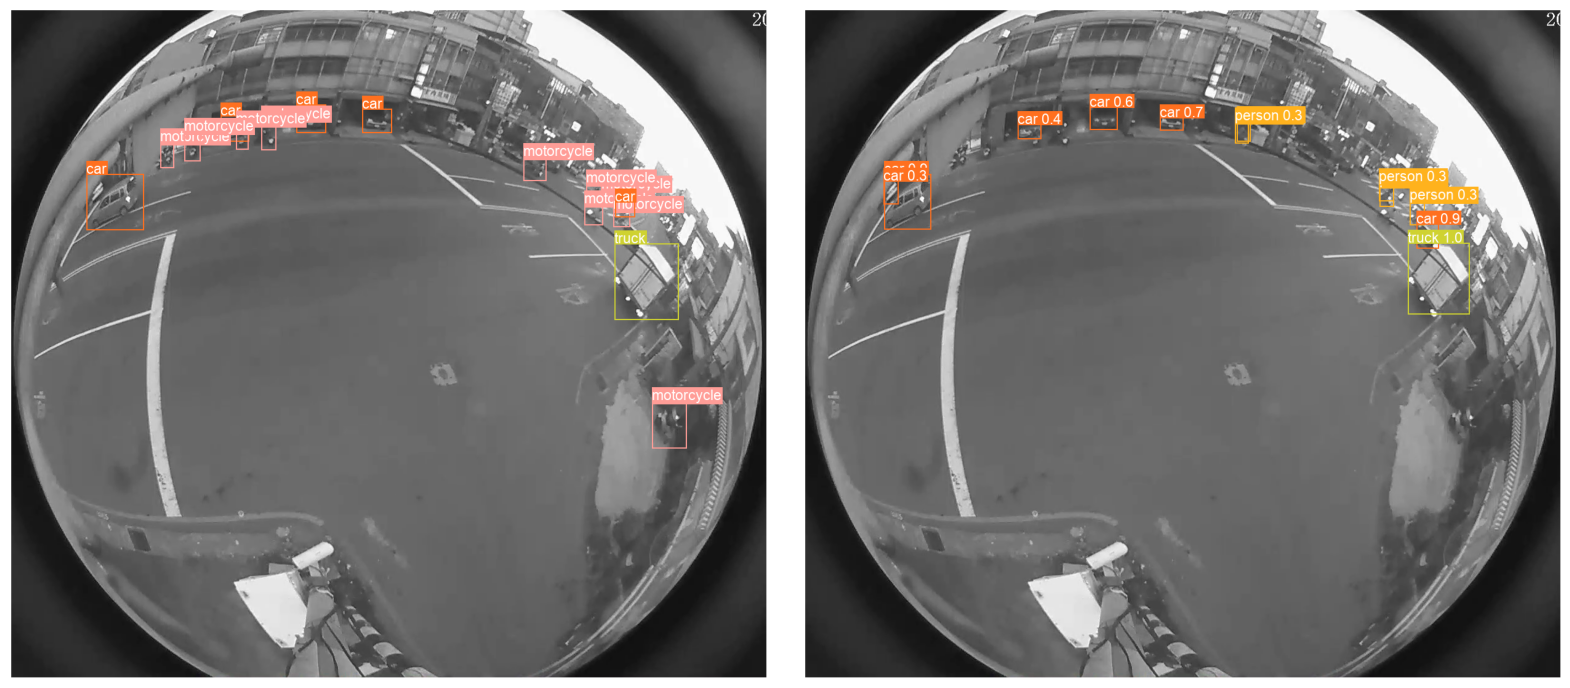

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(20, 12))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(img_gt)
ax[0].axis('off')
ax[1].imshow(img_pred)
ax[1].axis('off')
plt.gcf().set_facecolor('none')
plt.show()

## Internimage Results (Quantitaive)

In [8]:
from utils import FisheyeDetectionValidator
from ultralytics.utils import ops

class_name = {0: 'bus', 1: 'motorcycle', 2: 'car', 3: 'person', 4: 'truck'}
fisheye_eval = FisheyeDetectionValidator()
fisheye_eval.init_metrics(class_name)

In [9]:
# get ground truth
bboxes = np.array([gt["bbox"] for gt in gt_ann if gt["image_id"] == idx])
bboxes = ops.ltwh2xyxy(bboxes)
cls = np.array([gt["category_id"] for gt in gt_ann if gt["image_id"] == idx])
gt_array = torch.tensor(np.concatenate((bboxes, cls[:, np.newaxis]), axis=1))

# get predictions
bboxes = np.array([pred["bbox"] for pred in preds if pred["image_id"] == idx])
bboxes = ops.ltwh2xyxy(bboxes)
confs = np.array([pred["score"] for pred in preds if pred["image_id"] == idx])
cls_convert = {0:3, 2:2, 3:1, 5:0, 7:4}  # only need this with raw model trained with coco
cls = np.array([cls_convert[pred["category_id"]] for pred in preds if pred["image_id"] == idx])
pred_array = torch.tensor(np.concatenate((bboxes, confs[:, np.newaxis], cls[:, np.newaxis]), axis=1))

In [10]:
fisheye_eval.update_metrics([pred_array], [gt_array])

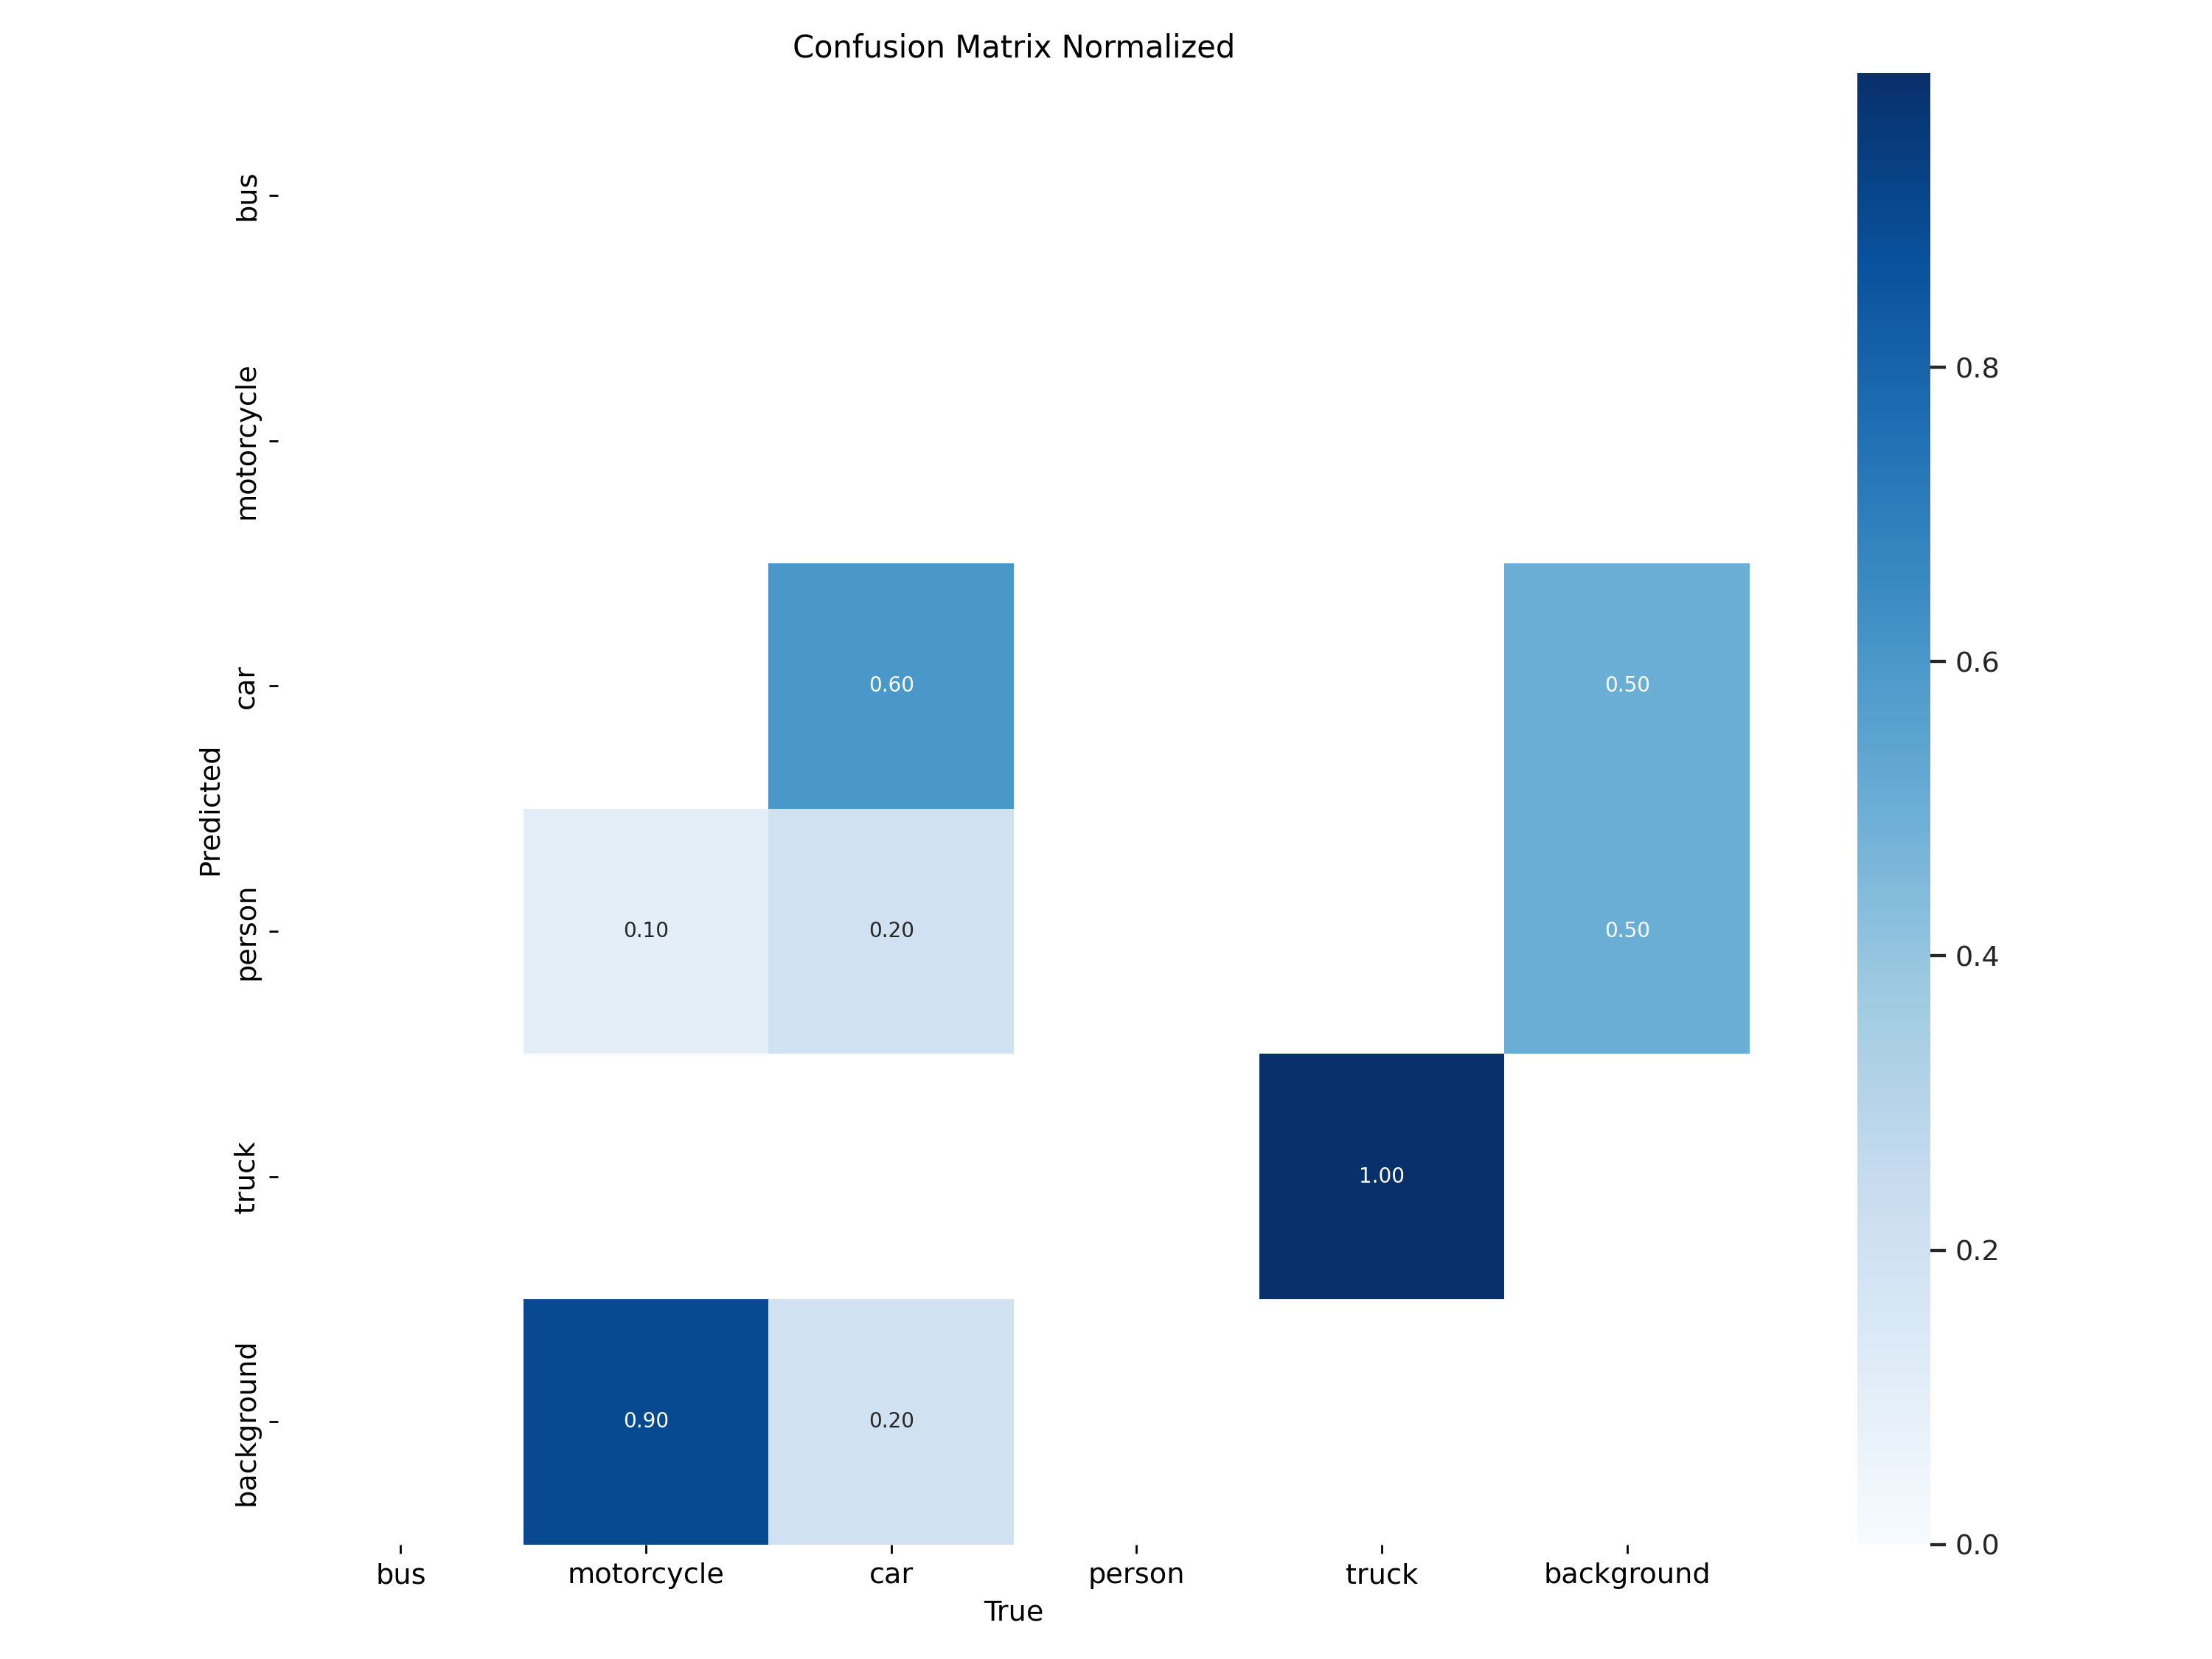

In [11]:
# confusion matrix was calculated based on boxes with >0.25 conf 
fisheye_eval.confusion_matrix.plot(save_dir="results", names=tuple(class_name.values()))
Image.open("results/confusion_matrix_normalized.png")

In [12]:
fisheye_eval.get_stats()

{'metrics/precision(B)': 0.7572747852238365,
 'metrics/recall(B)': 0.4666666666666666,
 'metrics/mAP50(B)': 0.5917786357786358,
 'metrics/mAP50-95(B)': 0.42350076683826676,
 'fitness': 0.4403285537323037}

## YOLOV8x Results (Qualitative)

In [13]:
pred_dir = "results/yolov8x_eval_fisheye_128.json"
with open(pred_dir) as f: preds = json.load(f)
# get all image_id from the predicitons
img_ids = []
for pred in preds:
  if not pred["image_id"] in img_ids:
    img_ids.append(pred["image_id"])

In [14]:
idx = "camera4_E_237.png"

In [15]:
from utils import plot_images

filename = [g["file_name"] for g in gt_img if g["id"] == 42237]
print(filename[0])
img = cv2.imread(image_dir + filename[0])

# get ground truth
bboxes = np.array([gt["bbox"] for gt in gt_ann if gt["image_id"] == 42237])
cls = np.array([gt["category_id"] for gt in gt_ann if gt["image_id"] == 42237])
names = {0: 'bus', 1: 'motorcycle', 2: 'car', 3: 'person', 4: 'truck'}

img_gt = plot_images(img, cls, bboxes, None, names, plot=False)

camera4_E_237.png


In [16]:
# get predictions
bboxes = np.array([pred["bbox"] for pred in preds if pred["image_id"] == idx])
confs = np.array([pred["score"] for pred in preds if pred["image_id"] == idx])
cls_convert = {0:3, 2:2, 3:1, 5:0, 7:4}  # only need this with raw model trained with coco
cls = np.array([cls_convert[pred["category_id"]] for pred in preds if pred["image_id"] == idx])
img_pred = plot_images(img, cls, bboxes, confs, names, conf_thres=0.25, plot=False)

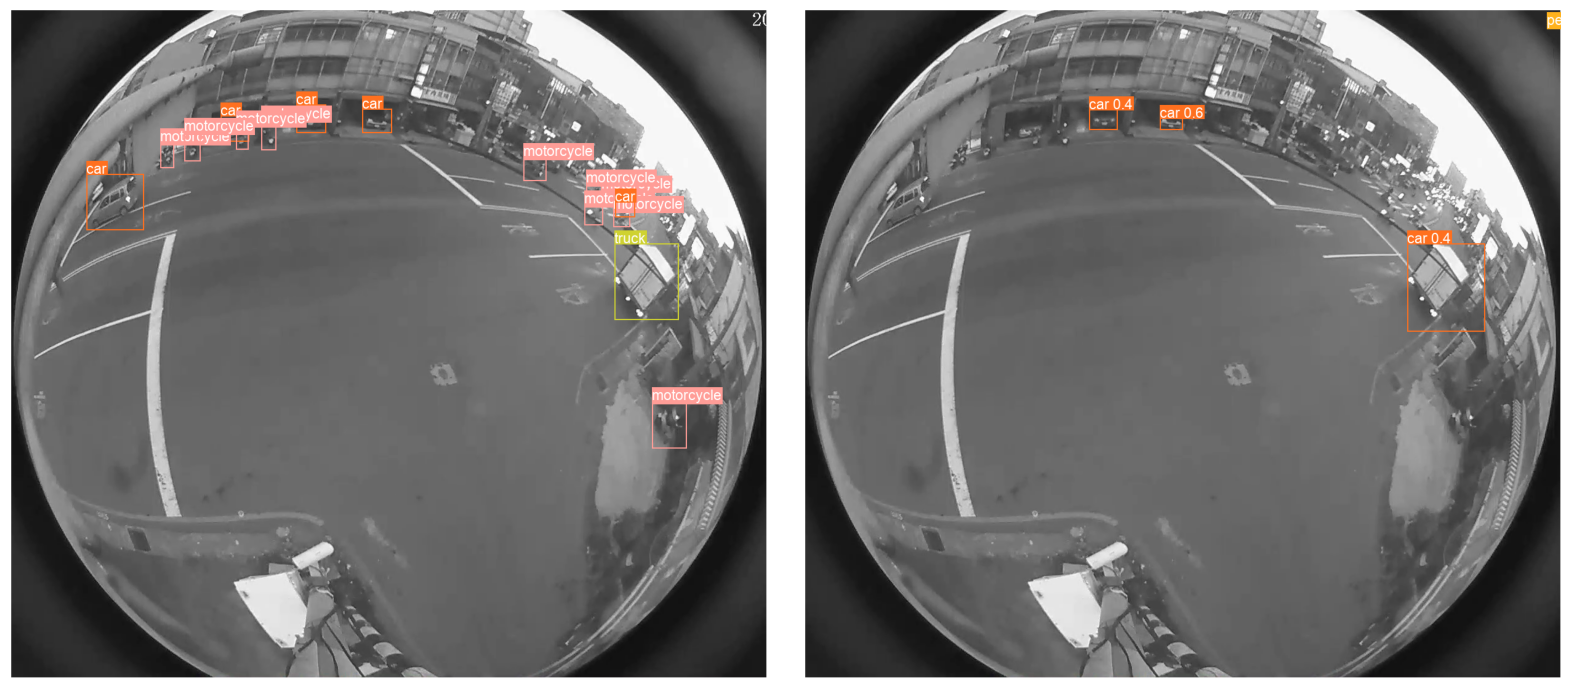

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20, 12))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(img_gt)
ax[0].axis('off')
ax[1].imshow(img_pred)
ax[1].axis('off')
plt.gcf().set_facecolor('none')
plt.show()

## YOLOV8x Results (Quantitaive)

In [18]:
from utils import FisheyeDetectionValidator
from ultralytics.utils import ops

class_name = {0: 'bus', 1: 'motorcycle', 2: 'car', 3: 'person', 4: 'truck'}
fisheye_eval = FisheyeDetectionValidator()
fisheye_eval.init_metrics(class_name)

In [19]:
# get ground truth
bboxes = np.array([gt["bbox"] for gt in gt_ann if gt["image_id"] == 42237])
bboxes = ops.ltwh2xyxy(bboxes)
cls = np.array([gt["category_id"] for gt in gt_ann if gt["image_id"] == 42237])
gt_array = torch.tensor(np.concatenate((bboxes, cls[:, np.newaxis]), axis=1))

# get predictions
bboxes = np.array([pred["bbox"] for pred in preds if pred["image_id"] == idx])
bboxes = ops.ltwh2xyxy(bboxes)
confs = np.array([pred["score"] for pred in preds if pred["image_id"] == idx])
cls_convert = {0:3, 2:2, 3:1, 5:0, 7:4}  # only need this with raw model trained with coco
cls = np.array([cls_convert[pred["category_id"]] for pred in preds if pred["image_id"] == idx])
pred_array = torch.tensor(np.concatenate((bboxes, confs[:, np.newaxis], cls[:, np.newaxis]), axis=1))

In [20]:
fisheye_eval.update_metrics([pred_array], [gt_array])

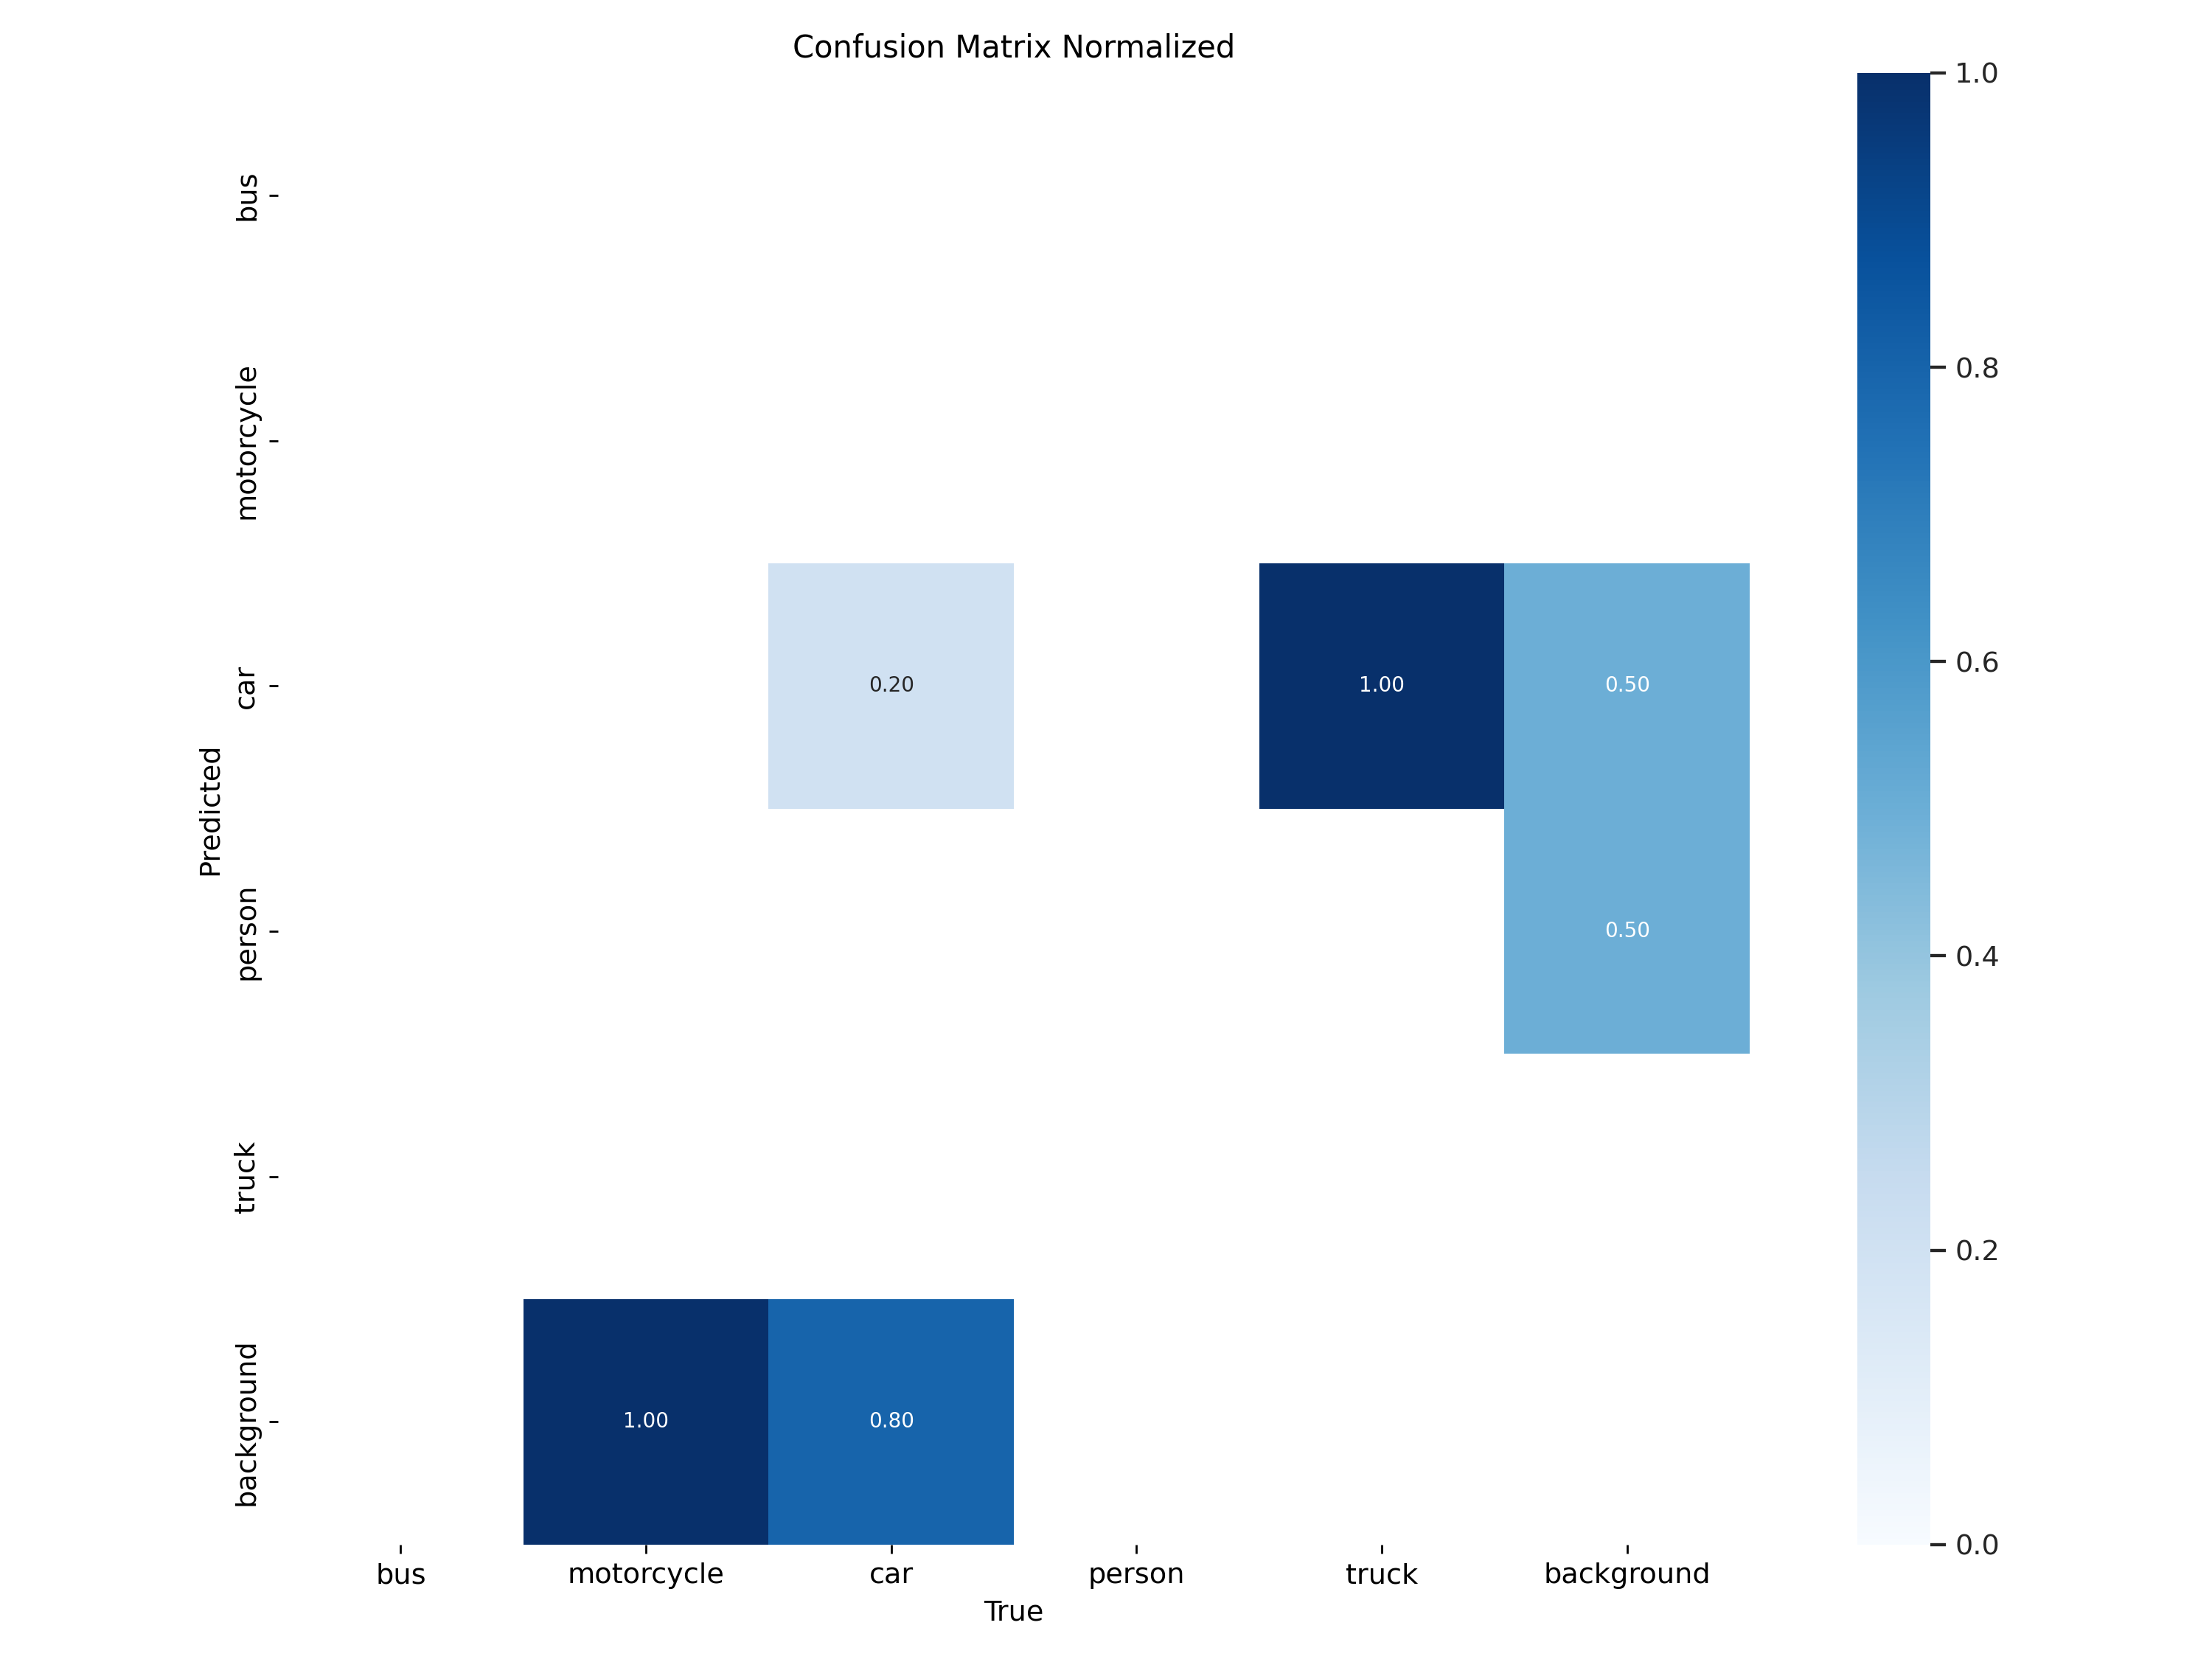

In [21]:
# confusion matrix was calculated based on boxes with >0.25 conf 
fisheye_eval.confusion_matrix.plot(save_dir="results", names=tuple(class_name.values()))
Image.open("results/confusion_matrix_normalized.png")

In [22]:
fisheye_eval.get_stats()

{'metrics/precision(B)': 0.8019200525819986,
 'metrics/recall(B)': 0.06666666666666667,
 'metrics/mAP50(B)': 0.041709457209457214,
 'metrics/mAP50-95(B)': 0.017271124197439983,
 'fitness': 0.019714957498641706}